In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

# import models
import spiking

# Plotting Functions

In [2]:
def plot_input_comparisons(original, masked, flipped, title_masked, title_flipped, num_images=5):
    fig, axes = plt.subplots(3, num_images, figsize=(12, 8))

    for i in range(num_images):
        # Original binarized image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Masked image input
        axes[1, i].imshow(masked[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Flipped image input
        axes[2, i].imshow(flipped[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    middle_col = num_images // 2
    axes[0, middle_col].set_title("Original Image", loc='center')
    axes[1, middle_col].set_title(title_masked, loc='center')
    axes[2, middle_col].set_title(title_flipped, loc='center')

    plt.show()

In [3]:
def plot_spiking_data(spikes, rates, pattern_type):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot spike train
    axes[0].eventplot(spikes, colors="black", orientation="vertical")
    axes[0].set_ylim(0, 1024)
    axes[0].set_title(f"{pattern_type} Spike Train")
    axes[0].set_xlabel("Time (ms)")
    axes[0].set_ylabel("Neuron Index")

    # Plot spike rates
    axes[1].bar(range(1024), rates)
    axes[1].set_title(f"{pattern_type} Firing Rates")
    axes[1].set_xlabel("Neuron Index")
    axes[1].set_ylabel("Frequency (Hz)")

    plt.show()

In [4]:
def plot_output_patterns(original, masked, grayscale, binarized, type, num_images=5):
    fig, axes = plt.subplots(4, num_images, figsize=(12, 8))

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Masked input
        axes[1, i].imshow(masked[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Grayscale output
        axes[2, i].imshow(grayscale[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

        # Binarized output
        axes[3, i].imshow(binarized[i].reshape(32, 32), cmap='gray')
        axes[3, i].axis('off')

    # Add row titles
    middle_col = num_images // 2
    axes[0, middle_col].set_title("Original", loc='center')
    axes[1, middle_col].set_title(f"Corrupted ({type}) Input", loc='center')
    axes[2, middle_col].set_title("Raw Grayscale Output", loc='center')
    axes[3, middle_col].set_title("Binarized Output", loc='center')

    plt.show()

# Initialize Model and Data

In [5]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

In [38]:
importlib.reload(spiking)

spyking_model = spiking.SpikingHN(N=1024)

num_patterns = 15

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
spyking_patterns = stored_images[idxs]
spyking_masked = masked_images[idxs]
spyking_flipped = flipped_images[idxs]

spyking_model.train(spyking_patterns)

# Plots

### Plot masked and flipped image examples

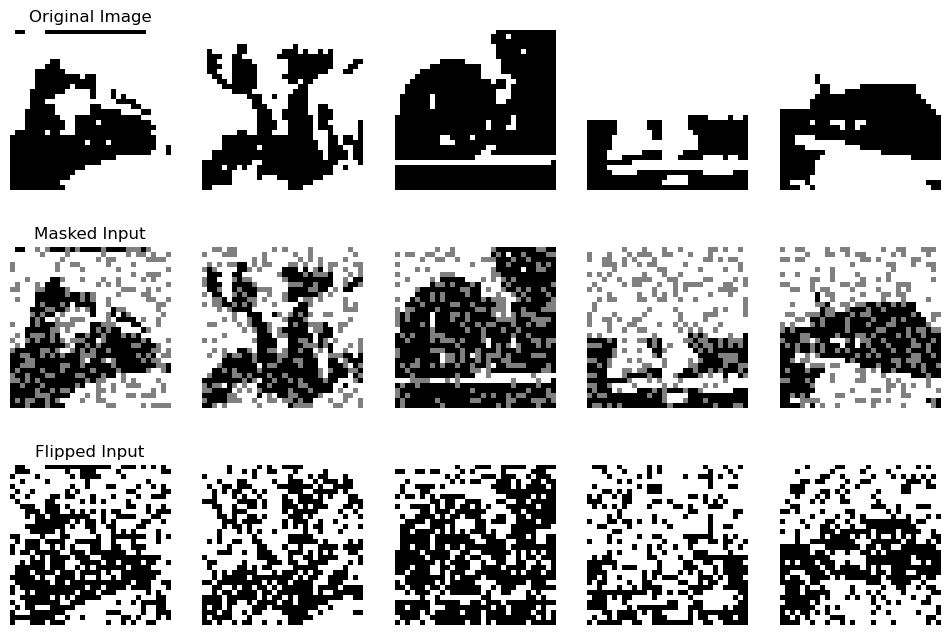

In [ ]:
plot_input_comparisons(spyking_patterns[:5], spyking_masked[:5], spyking_flipped[:5],
    "Masked Input", "Flipped Input", 5)

### Plot masked and flipped input firing data for one image

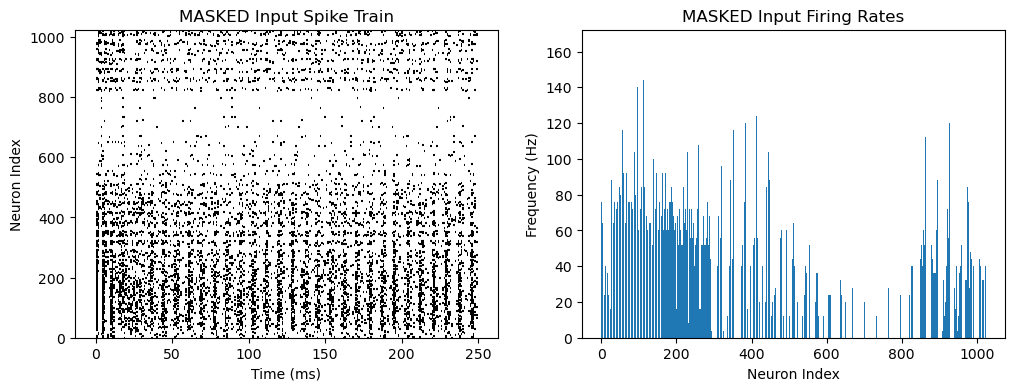

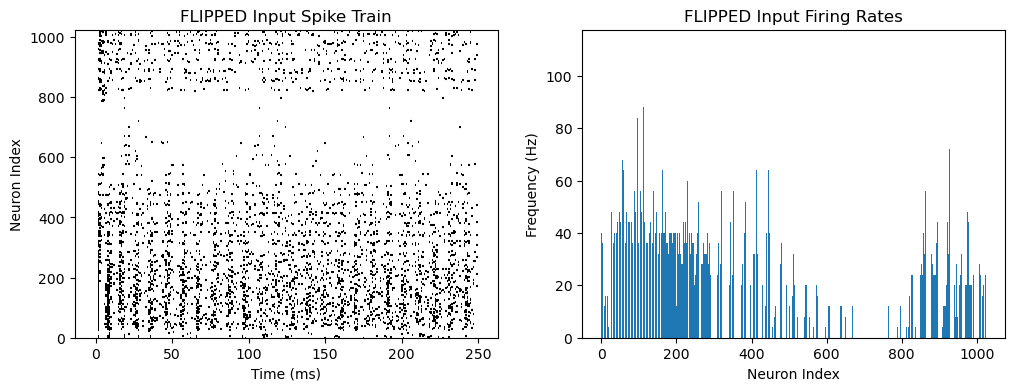

In [40]:
masked_firings, masked_rates = spyking_model.forward_pattern(spyking_masked[0])
flipped_firings, flipped_rates = spyking_model.forward_pattern(spyking_flipped[0])

plot_spiking_data(masked_firings, masked_rates, "MASKED Input")
plot_spiking_data(flipped_firings, flipped_rates, "FLIPPED Input")

### Pass 5 masked and 5 flipped patterns into model for retrieval

In [41]:
grayscale_masked, binarized_masked = spyking_model.forward(spyking_masked[:5])
grayscale_flipped, binarized_flipped = spyking_model.forward(spyking_flipped[:5])

### Output comparison (masked)

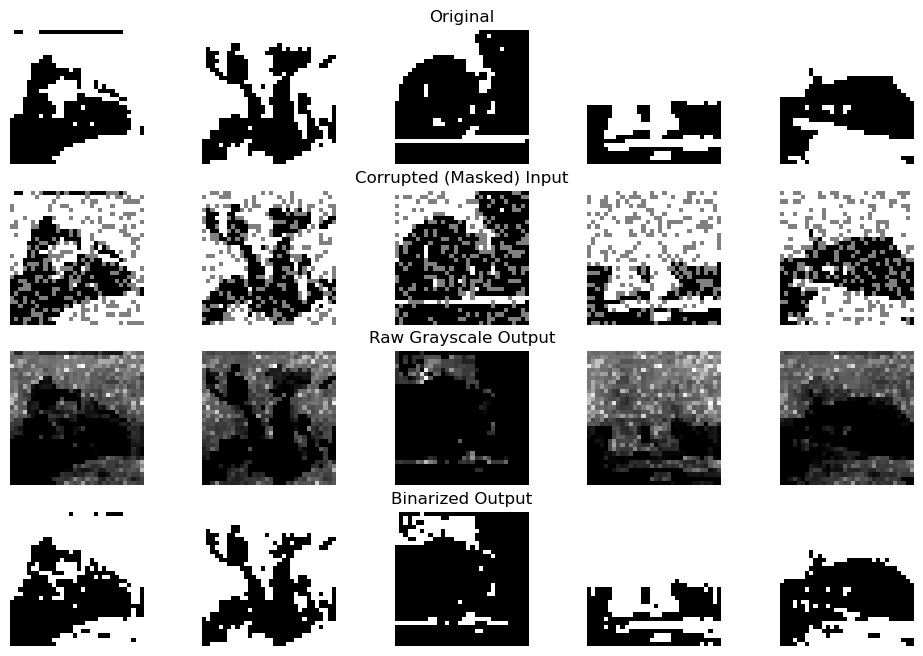

In [ ]:
plot_output_patterns(spyking_patterns[:5], spyking_masked[:5], grayscale_masked, binarized_masked, "Masked")

### Output comparison (flipped)

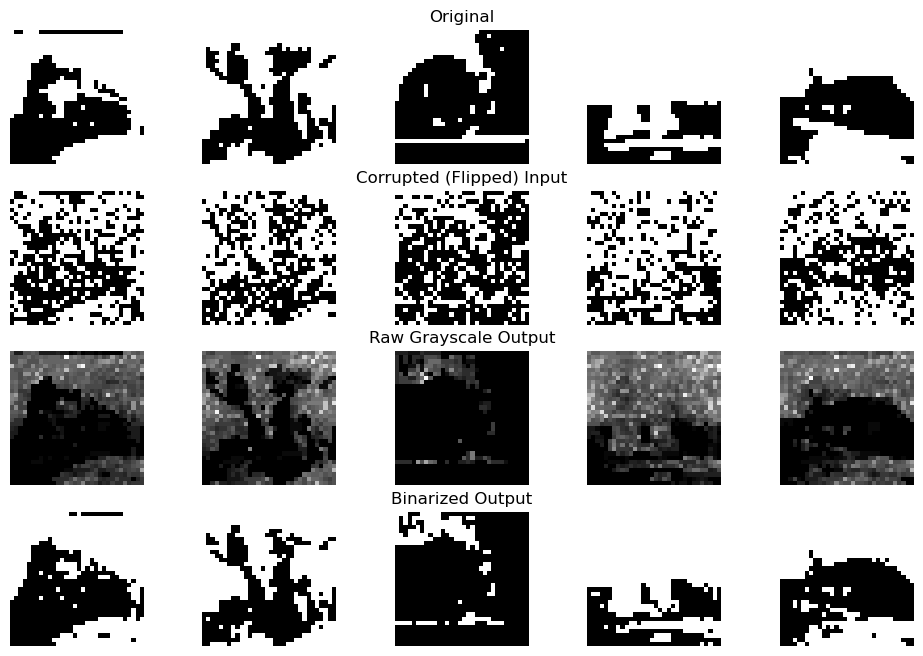

In [ ]:
plot_output_patterns(spyking_patterns[:5], spyking_flipped[:5], grayscale_flipped, binarized_flipped, "Flipped")

### Reconstructing images for increasing stored patterns
#### (also collecting MSE data)

In [ ]:
importlib.reload(spiking)

results = []
num_patterns_list = [5, 10, 15, 20, 30, 50, 80]
selected_idxs = set()
plot_idx = []
mse_values = []

for i, num_patterns in enumerate(num_patterns_list):
    
    spiking_hn = spiking.SpikingHN(N=1024)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=num_patterns, replace=False)

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[list(selected_idxs)]

    spiking_hn.train(baseline_original)

    retrieved_grayscale, retrieved_binary = spiking_hn.forward(baseline_masked)

    binarized_for_mse = np.where(retrieved_binary == 255, 1, -1)
    mse = np.sum((baseline_original - binarized_for_mse)**2) / num_patterns

    # Store the results for plotting later
    # results.append(retrieved_grayscale[plot_idx])
    mse_values.append(mse)

# # Create a large figure with an appropriate size
# plt.figure(figsize=(20, 10))

# # Loop through the rows (images)
# for row, idx in enumerate(plot_idx, start=1):

#     # Plot the original image
#     plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
#     plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
#     plt.title(f'Original')
#     plt.axis('off')

#     # Plot the retrieved images for each number of patterns
#     for i, num_patterns in enumerate(num_patterns_list):

#         image_to_plot = results[i][row-1].reshape(32, 32)

#         # Plot the image on the appropriate subplot axis
#         plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
#         plt.imshow(image_to_plot, cmap='gray')
#         plt.title(f'{num_patterns} Patterns')
#         plt.axis('off')

# # Display the plots
# plt.tight_layout()
# plt.show()

### Plotting the MSE over increasing stored patterns

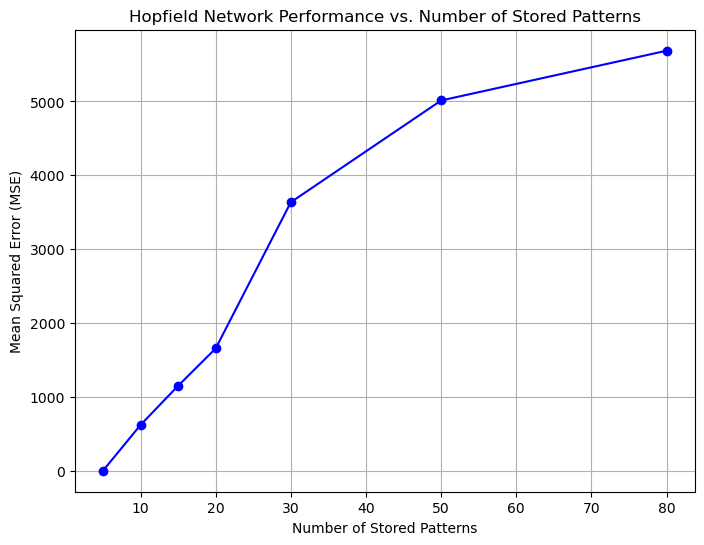

In [ ]:
# MSE calculations use binarized versions of outputs
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, mse_values, marker='o', linestyle='-', color='b')
plt.title("Hopfield Network Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()